In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage as nd
import cv2

from auxiliary import values as v
# from auxiliary.utils.colors import bcolors as c
from auxiliary.data import imaging
from auxiliary.utils.timer import LoadingBar

from filtering import cardiac_region as cr
from filtering.run_filter_tissue import filter_by_tissue
from feature_extraction.feature_extractor import filter_by_margin, filter_by_volume
from auxiliary.data.dataset_ht import HtDataset
from nuclei_segmentation.run_cellpose import predict
import json

GPU activated: False


In [47]:
# img_path = v.data_path + 'Gr1/RawImages/Nuclei/QC_CROP/20190208_E2_DAPI_decon_0.5_crop.nii.gz'
# img_path_gt = v.data_path + 'Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_GT.nii.gz'
# img_path_pred = v.data_path + 'Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_2D_5_6_45_M_BI_all.nii.gz'
# 
# img = imaging.read_image(img_path, axes='XYZ', verbose=1)
# img_gt = imaging.read_image(img_path_gt, axes='XYZ', verbose=1)
# img_pred = imaging.read_image(img_path_pred, axes='XYZ', verbose=1)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/QC_CROP/20190208_E2_DAPI_decon_0.5_crop.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_GT.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/QC_CROP/20190208_E2_nuclei_mask_crop_2D_5_6_45_M_BI_all.nii.gz


In [51]:
# cell_id = 70
# 
# margins = cr.get_cell_margins(img_gt, cell_id)
# 
# crop_gt = cr.crop_img(img_gt, margins, verbose=1)
# crop_pred = cr.crop_img(img_pred, margins, verbose=1)
# 
# crop_gt[crop_gt != cell_id] = 0
# crop_pred[crop_pred != 84] = 0
# 
# imaging.save_tiff_imagej_compatible('crop_gt.tif', crop_gt, axes='YXZ')
# imaging.save_tiff_imagej_compatible('crop_pred.tif', crop_pred, axes='YXZ')

Cropped image shape: (27, 22, 40)
Cropped image shape: (27, 22, 40)


/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/csbdeep/io/__init__.py:43: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


Generate artificial image with circles

In [25]:
def generate_gt():
    img = np.zeros((100, 100), dtype=np.uint8)
    
    cv2.circle(img, (20, 20), 10, 1, -1)
    cv2.circle(img, (40, 40), 7, 2, -1)
    
    cv2.circle(img, (60, 60), 10, 3, -1)
    cv2.circle(img, (70, 70), 11, 4, -1)
    
    return img

def generate_pred(type='perfect'):
    img = np.zeros((100, 100), dtype=np.uint8)
    
    if type == 'perfect':
        cv2.circle(img, (20, 20), 10, 1, -1)
        cv2.circle(img, (40, 40), 7, 2, -1)
        
        cv2.circle(img, (60, 60), 10, 3, -1)
        cv2.circle(img, (70, 70), 11, 4, -1)     
    elif type == 'under':
        cv2.circle(img, (20, 20), 7, 1, -1)
        cv2.circle(img, (40, 40), 3, 2, -1)
        
        cv2.circle(img, (60, 60), 7, 3, -1)
        cv2.circle(img, (70, 70), 8, 4, -1)
    elif type == 'over':
        cv2.circle(img, (20, 20), 15, 1, -1)
        cv2.circle(img, (40, 40), 11, 2, -1)
        
        cv2.circle(img, (60, 60), 15, 3, -1)
        cv2.circle(img, (70, 70), 16, 4, -1)
        
    elif type == 'wrong':
        cv2.circle(img, (20, 20), 13, 1, -1)
        # cv2.circle(img, (40, 40), 9, 2, -1)
        
        cv2.circle(img, (60, 60), 13, 2, -1)
        cv2.circle(img, (60, 70), 12, 3, -1)
        
        cv2.circle(img, (10, 70), 10, 4, -1)
    
    return img

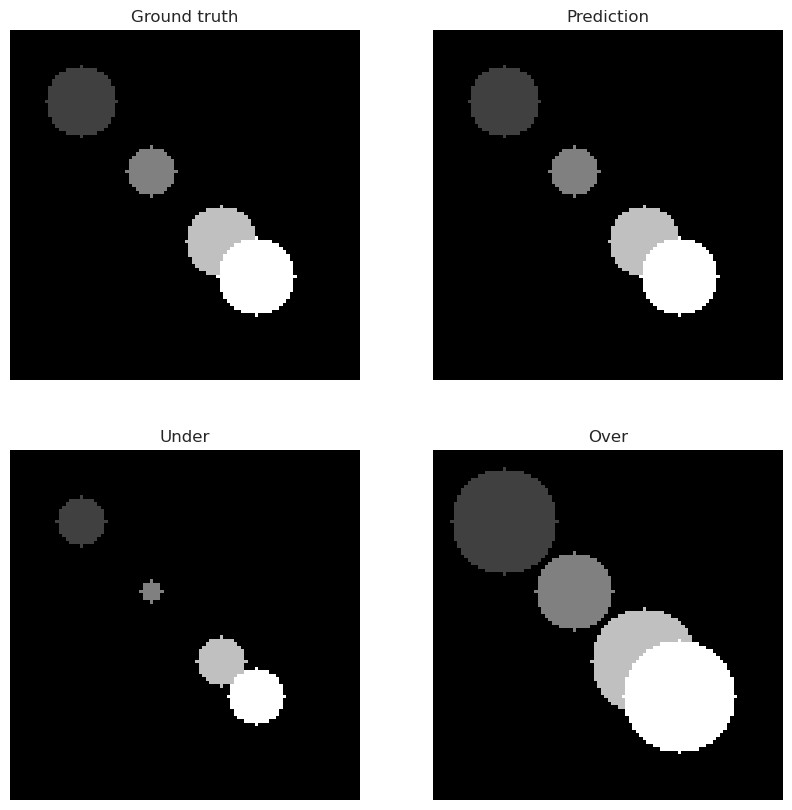

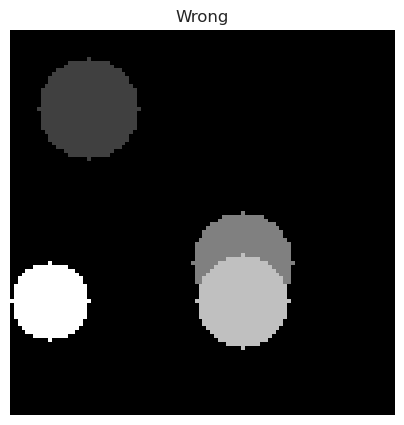

In [26]:
gt = generate_gt()
pred_perfect = generate_pred('perfect')
pred_under = generate_pred('under')
pred_over = generate_pred('over')
pred_wrong = generate_pred('wrong')

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.imshow(gt, cmap='gray'); plt.title('Ground truth'); plt.axis('off')
plt.subplot(2, 2, 2); plt.imshow(pred_perfect, cmap='gray'); plt.title('Prediction'); plt.axis('off')
plt.subplot(2, 2, 3); plt.imshow(pred_under, cmap='gray'); plt.title('Under'); plt.axis('off')
plt.subplot(2, 2, 4); plt.imshow(pred_over, cmap='gray'); plt.title('Over'); plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(pred_wrong, cmap='gray'); plt.title('Wrong'); plt.axis('off')
plt.show()

Metrics:
- VJI: Volume Jaccard Index
- ROS: Ratio of Over-Segmentation
- RUS: Ratio of Under-Segmentation
- BFScore: Boundary F1 Score

In [28]:
def JI(gt, pred):
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    
    jaccard_index = association['jaccard'].sum() / len(association)
    print(association)
    print(jaccard_index)
    
    return jaccard_index
    
ji_perfect = JI(gt, pred_perfect)
ji_over = JI(gt, pred_over)
ji_under = JI(gt, pred_under)
ji_wrong = JI(gt, pred_wrong)

   pred  gt  jaccard
0     1   1      1.0
1     2   2      1.0
2     3   3      1.0
3     4   4      1.0
1.0
   pred  gt   jaccard
0     1   1  0.447109
1     2   2  0.395225
2     3   3  0.304802
4     4   4  0.473024
0.40503989435049936
   pred  gt   jaccard
0     1   1  0.470032
1     2   2  0.194631
2     3   3  0.448148
4     4   4  0.522546
0.40883924636770946
   pred  gt   jaccard
0     1   1  0.599244
1     2   3  0.375648
2     3   4  0.298413
3     0   2  0.000000
0.318326055784796


In [30]:
def VJI(gt, pred):
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
            
    # Calculate volumes
    cell_gt_volumes = np.array([np.sum(gt == lab) for lab in gt_cells])
    cell_gt_volumes_dict = dict(zip(gt_cells, cell_gt_volumes))
    
    association['volume_gt'] = association.apply(lambda row: cell_gt_volumes_dict[row['gt']], axis=1)
    
    # Calculate Weighted Jaccard Index
    association['weighted_jaccard'] = association['jaccard'] * association['volume_gt']
    
    vji = association['weighted_jaccard'].sum() / np.sum(cell_gt_volumes)
    print(association)
    print(vji)
    
    return vji
    
vji_perfect = VJI(gt, pred_perfect)
vji_over = VJI(gt, pred_over)
vji_under = VJI(gt, pred_under)
vji_wrong = VJI(gt, pred_wrong)

   pred  gt  jaccard  volume_gt  weighted_jaccard
0     1   1      1.0        317             317.0
1     2   2      1.0        149             149.0
2     3   3      1.0        244             244.0
3     4   4      1.0        377             377.0
1.0
   pred  gt   jaccard  volume_gt  weighted_jaccard
0     1   1  0.447109        317        141.733427
1     2   2  0.395225        149         58.888594
2     3   3  0.304802        244         74.371608
4     4   4  0.473024        377        178.329987
0.41704104553407984
   pred  gt   jaccard  volume_gt  weighted_jaccard
0     1   1  0.470032        317        149.000000
1     2   2  0.194631        149         29.000000
2     3   3  0.448148        244        109.348148
4     4   4  0.522546        377        197.000000
0.4455824729973764
   pred  gt   jaccard  volume_gt  weighted_jaccard
0     1   1  0.599244        317        189.960302
1     2   3  0.375648        244         91.658031
2     3   4  0.298413        377        112.

In [43]:
def BFS(gt, pred, threshold=2, draw=False):
    def calc_precision_recall(contours_a, contours_b, threshold):
        x = contours_a
        y = contours_b
    
        xx = np.array(x)
        xx = xx.reshape(-1, 2)
        
        yy = np.array(y)
        yy = yy.reshape(-1, 2)
        hits = []
        for yrec in yy:
            d = np.square(xx[:,0] - yrec[0]) + np.square(xx[:,1] - yrec[1])
            hits.append(np.any(d < threshold*threshold))
        top_count = np.sum(hits)
    
        try:
            precision_recall = top_count / len(y)
        except ZeroDivisionError:
            precision_recall = 0
    
        return precision_recall, top_count, len(y)
    
    gt_cells = [lab for lab in np.unique(gt) if lab != 0]
    pred_cells = [lab for lab in np.unique(pred) if lab != 0]
    
    # Cell overlap
    overlap_list = []
    
    for pred_cell in pred_cells:
        pred_mask = pred == pred_cell
        for gt_cell in gt_cells:
            gt_mask = gt == gt_cell
            intersection = np.logical_and(pred_mask, gt_mask).sum()
            union = np.logical_or(pred_mask, gt_mask).sum()
            jaccard = intersection / union if union > 0 else 0
            if np.sum(jaccard) > 0:
                overlap_list.append({'pred': pred_cell, 'gt': gt_cell, 'jaccard': np.sum(jaccard)})
                
    overlap = pd.DataFrame(overlap_list)
    
    # Associate cells
    association = overlap.loc[overlap.groupby('pred')['jaccard'].idxmax()]
    
    # Add the missing reference cells
    missing = set(gt_cells) - set(association['gt'])
    rows = []
    if len(missing) > 0:
        for m in missing:
            rows.append({'pred': 0, 'gt': m, 'jaccard': 0})
        association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
        
    # # Add the missing predicted cells
    # missing = set(pred_cells) - set(association['pred'])
    # rows = []
    # if len(missing) > 0:
    #     for m in missing:
    #         rows.append({'pred': m, 'gt': 0, 'jaccard': 0})
    #     association = pd.concat([association, pd.DataFrame(rows)], ignore_index=True)
            
    print(association)
            
    bfscores = []
    volumes_gt = []
        
    for id in association['gt']:
        print(id)
        gt_mask = gt == id
        
        contours, _ = cv2.findContours(
            gt_mask.astype(np.uint8), cv2.RETR_LIST, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        contours_gt = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_gt.append(contours[i][j])
                
        if contours_gt:
            volume = cv2.contourArea(np.array(contours_gt))
            volumes_gt.append(volume)
    
        if draw:
            img = np.zeros(shape=(gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
            img[gt == id, 0] = 128
            img = cv2.drawContours(img, contours, -1, (255, 0, 0), 1)
    
        try:
            associated_id = association.loc[association['gt'] == id, 'pred'].values[0]
        except IndexError:
            associated_id = 0
            
        if associated_id == 0:
            bfscores.append(0)
            continue
        
        pred_mask = pred == associated_id
        
        contours, _ = cv2.findContours(
            pred_mask.astype(np.uint8), cv2.RETR_LIST, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        contours_pred = []
        for i in range(len(contours)):
            for j in range(len(contours[i])):
                contours_pred.append(contours[i][j])
                
        if draw:
            img[pred == associated_id, 2] = 128
            img = cv2.drawContours(img, contours, -1, (0, 0, 255), 1)
            
        precission, num, den = calc_precision_recall(contours_gt, contours_pred, threshold)
        print(precission, num, den)
        
        recall, num, den = calc_precision_recall(contours_pred, contours_gt, threshold)
        print(recall, num, den)
        
        try:
            bfscore = 2 * precission * recall / (precission + recall)
        except ZeroDivisionError:
            bfscore = 0
            
        bfscores.append(bfscore)
        
        if draw:
            cv2.imshow('img', img)
            cv2.waitKey(0)
            
    association['bfscore'] = bfscores  
    association['w_bfscore'] = association['bfscore'] * np.array(volumes_gt)
    
    total_volume = np.nansum(volumes_gt)
    bfscore = np.nanmean(bfscores)
    fw_bfscore = np.nansum(
        [score * volume for score, volume in zip(bfscores, volumes_gt)]
    ) / total_volume
    
    print(bfscore, fw_bfscore)
    
    if draw:
        cv2.destroyAllWindows()
    
    return bfscore, fw_bfscore

# bfscore_perfect, wbfscore_perfect = BFS(gt, pred_perfect, draw=True)
# bfscore_over, wbfscore_over = BFS(gt, pred_over, draw=True, threshold=4)
# bfscore_under, wbfscore_under = BFS(gt, pred_under, draw=True, threshold=4)
# bfscore_wrong, wbfscore_wrong = BFS(gt, pred_wrong, draw=True, threshold=4)

In [36]:
bfscore_perfect, wbfscore_perfect = BFS(gt, pred_perfect, draw=True, threshold=4)

   pred  gt  jaccard
0     1   1      1.0
1     2   2      1.0
2     3   3      1.0
3     4   4      1.0
1
1.0 36 36
1.0 36 36
2
1.0 20 20
1.0 20 20
3
1.0 32 32
1.0 32 32
4
1.0 36 36
1.0 36 36
1.0 1.0


In [42]:
bfscore_over, wbfscore_over = BFS(gt, pred_over, draw=True, threshold=4)

   pred  gt   jaccard
0     1   1  0.447109
1     2   2  0.395225
2     3   3  0.304802
4     4   4  0.473024
1
0.0 0 52
0.0 0 36
2
0.4444444444444444 16 36
0.6 12 20
3
0.24 12 50
0.375 12 32
4
0.0 0 52
0.0 0 36
0.4016606123508044 0.13224743971278183


In [39]:
bfscore_under, wbfscore_under = BFS(gt, pred_under, draw=True, threshold=4)

   pred  gt   jaccard
0     1   1  0.470032
1     2   2  0.194631
2     3   3  0.448148
4     4   4  0.522546
1
1.0 20 20
1.0 36 36
2
0.25 4 16
0.4 8 20
3
1.0 22 22
1.0 32 32
4
1.0 36 36
1.0 36 36
0.8269230769230769 0.9081632653061225


In [46]:
bfscore_wrong, wbfscore_wrong = BFS(gt, pred_wrong, draw=True, threshold=4)

   pred  gt   jaccard
0     1   1  0.599244
1     2   3  0.375648
2     3   4  0.298413
3     0   2  0.000000
1
1.0 36 36
1.0 36 36
3
0.7777777777777778 28 36
0.78125 25 32
4
0.2222222222222222 8 36
0.2222222222222222 8 36
2
0.5004330611234843 0.5441459731628361
